In [ ]:
!pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#restart after

In [ ]:
!pip install scipy==1.10.1
#srestart after

In [2]:
!pip install geoopt torch

In [7]:

!git clone https://github.com/eamid/trimap.git

!pip install /kaggle/working/trimap


Cloning into 'trimap'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 397 (delta 36), reused 27 (delta 11), pack-reused 326 (from 1)
Receiving objects: 100% (397/397), 24.34 MiB | 18.37 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Processing ./trimap
  Preparing metadata (setup.py) ... done
  Created wheel for trimap: filename=trimap-1.1.4-py3-none-any.whl size=15441 sha256=901a54bc243a461d3bd8e8718471ff4dc21a16e8d233ad083da0609d526b8dd7
  Stored in directory: /tmp/pip-ephem-wheel-cache-c4u1c5t5/wheels/45/3a/6c/c020cce2cbdba5170c6844451da08219301c3edadc9e02848b
Successfully built trimap


In [8]:
!pip install -q sentence-transformers geoopt umap-learn tqdm


In [4]:
#!pip install huggingface_hub


In [5]:
#trying cuda
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
x = torch.rand(10000, 10000).to(device)
x = torch.mm(x, x)
torch.cuda.synchronize()
print("Dummy tensor multiplied on", x.device)


Using device: cuda
Dummy tensor multiplied on cuda:0


In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()


In [9]:
import numpy as np
import torch
import torch.nn as nn
import geoopt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import os
import random
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from trimap import TRIMAP



# Setup
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs("embeddings", exist_ok=True)
os.makedirs("losses", exist_ok=True)

# Load Fashion MNIST (1000 samples)
(X, y), (_, _) = fashion_mnist.load_data()
X = X[:1000].reshape(-1, 28 * 28).astype(np.float32) / 255.0
y = y[:1000]

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Label names from Fashion MNIST
fashion_labels = [
    "T-shirt", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"
]

# Get sentence embeddings of labels
model = SentenceTransformer("all-MiniLM-L6-v2")
label_embeddings = model.encode(fashion_labels)
similarity_matrix = cosine_similarity(label_embeddings)

# Build semantic triplets based on cosine similarity
triplets = []
threshold = 0.65  # similarity threshold for "positive" pairs
for i in range(len(y)):
    for j in range(len(y)):
        if i != j:
            sim = similarity_matrix[y[i], y[j]]
            if sim >= threshold:
                # pick a semantically dissimilar third item
                k_candidates = [k for k in range(len(y)) if k != i and k != j and similarity_matrix[y[i], y[k]] < 0.4]
                if k_candidates:
                    k = random.choice(k_candidates)
                    triplets.append((i, j, k))

# Convert to tensor
triplets = torch.tensor(triplets).to(device)
print(f"Generated {len(triplets)} semantic triplets.")

# Save to .npy file
np.save("semantic_triplets_fashion.npy", triplets.cpu().numpy())
print("Triplets saved to semantic_triplets_fashion.npy")




Using device: cuda
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated 120980 semantic triplets.
Triplets saved to semantic_triplets_fashion.npy


In [12]:
import numpy as np
import torch
import geoopt
import os
from tqdm import trange
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from trimap import TRIMAP
from sklearn.metrics import silhouette_samples
import pandas as pd

# Load dataset
(X, y), (_, _) = fashion_mnist.load_data()
X = X[:1000].reshape(-1, 28 * 28).astype(np.float32) / 255.0
y = y[:1000]


# X = X.reshape(-1, 28 * 28)
# (X, y), _ = fashion_mnist.load_data()  # X: (60000, 28, 28), y: (60000,)


# Load semantic triplets
triplets = torch.tensor(np.load("semantic_triplets_fashion.npy"), dtype=torch.long)

# Output folder
os.makedirs("output", exist_ok=True)

# Silhouette computation
def compute_per_class_silhouette(embedding, labels):
    sil_samples = silhouette_samples(embedding, labels)
    return {c: np.mean(sil_samples[labels == c]) for c in np.unique(labels)}

# Training function with structure regularization
def train_with_early_stopping(
    embedding,
    triplets,
    max_epochs=300,
    patience=10,
    margin=0.1,
    loss_threshold=0.015,
    acc_threshold=0.995,
    reg_weight=0.1,
    original_dr_embedding=None, 
    method = None,
    verbose=True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    manifold = geoopt.PoincareBall(c=1.0)

    # original_embed = torch.tensor(embedding, dtype=torch.float32).to(device)
    # embed = geoopt.ManifoldParameter(original_embed.clone(), manifold=manifold)
    original_embed = torch.tensor(embedding, dtype=torch.float32).to(device)
    embed = geoopt.ManifoldParameter(original_embed.clone(), manifold=manifold)
    
    if original_dr_embedding is not None:
        original_dr_embedding = torch.tensor(original_dr_embedding, dtype=torch.float32).to(device)


    optimizer = torch.optim.Adam([embed], lr=0.01)
    best_loss, no_improve = float('inf'), 0
    losses = []
    triplets = triplets.to(device)

    for epoch in trange(max_epochs, desc="Training"):
        optimizer.zero_grad()
        anchors, positives, negatives = embed[triplets[:, 0]], embed[triplets[:, 1]], embed[triplets[:, 2]]
        d_ap = manifold.dist(anchors, positives)
        d_an = manifold.dist(anchors, negatives)

        triplet_loss = torch.clamp(d_ap - d_an + margin, min=0).mean()
        reg_loss = ((embed - original_embed) ** 2).mean()
        total_loss = triplet_loss + reg_weight * reg_loss

        # UMAP regularization to preserve local geometry
        if method == "umap" and original_dr_embedding is not None:
            recon_loss = ((embed - original_dr_embedding) ** 2).mean()
            total_loss += 0.001 * recon_loss  #weight reg umap




        total_loss.backward()
        optimizer.step()

        triplet_acc = (d_ap < d_an).float().mean().item()
        current_loss = total_loss.item()
        losses.append(current_loss)

        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch} - Loss: {current_loss:.4f} - Triplet Acc: {triplet_acc:.4f}")

        # Early stopping condition 1: low loss or no improvement
        if current_loss < loss_threshold or no_improve >= patience:
            print(f"[STOP] Patience or low loss triggered.")
            break
        
        # Early stopping condition 2: high triplet accuracy *after* min epochs
        if triplet_acc > acc_threshold and epoch >= 50:
            print(f"[STOP] High triplet acc after sufficient training.")
            break


        if current_loss + 1e-5 < best_loss:
            best_loss = current_loss
            no_improve = 0
        else:
            no_improve += 1

    return embed.detach().cpu().numpy(), losses

# Main pipeline
results = {}
for method in ["pca", "tsne", "umap", "trimap"]:
    print(f"--- Running {method.upper()} ---")

    if method == "pca":
        X_2d = PCA(n_components=2).fit_transform(X)
    elif method == "tsne":
        X_2d = TSNE(n_components=2, init='pca', random_state=42).fit_transform(X)
    elif method == "umap":
        X_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
    elif method == "trimap":
        X_2d = TRIMAP(n_dims=2).fit_transform(X)

    np.save(f"output/original_embedding_{method}.npy", X_2d)

    X_norm = X_2d / (np.linalg.norm(X_2d, axis=1, keepdims=True).clip(min=1e-5)) * 0.8
    X_norm = np.clip(X_norm, a_min=None, a_max=1 - 1e-5)

   
    optimized, loss_list = train_with_early_stopping(
        X_norm,
        triplets,
        method=method,
        original_dr_embedding=X_2d
    )

    results[method] = {"embedding": optimized, "loss": loss_list}

    np.save(f"output/embedding_{method}.npy", optimized)
    np.save(f"output/loss_{method}.npy", np.array(loss_list))

    per_class_sil = compute_per_class_silhouette(optimized, y)
    results[method]["per_class_silhouette"] = per_class_sil
    df_sil = pd.DataFrame(list(per_class_sil.items()), columns=["class", "silhouette"])
    df_sil.to_csv(f"output/silhouette_per_class_{method}.csv", index=False)

    print(f"\n[Silhouette Scores for {method.upper()}]")
    for cls, score in sorted(per_class_sil.items()):
        print(f"  Class {cls}: {score:.4f}")

print("All methods completed and saved.") #2.36







--- Running PCA ---


Training:   2%|▏         | 6/300 [00:00<00:05, 56.47it/s]

Epoch 0 - Loss: 0.2889 - Triplet Acc: 0.7681
Epoch 10 - Loss: 0.1446 - Triplet Acc: 0.8670


Training:  10%|█         | 30/300 [00:00<00:01, 158.81it/s]

Epoch 20 - Loss: 0.0873 - Triplet Acc: 0.9174
Epoch 30 - Loss: 0.0572 - Triplet Acc: 0.9394


Training:  19%|█▊        | 56/300 [00:00<00:01, 201.44it/s]

Epoch 40 - Loss: 0.0420 - Triplet Acc: 0.9531
Epoch 50 - Loss: 0.0319 - Triplet Acc: 0.9635
Epoch 60 - Loss: 0.0251 - Triplet Acc: 0.9712
Epoch 70 - Loss: 0.0201 - Triplet Acc: 0.9772


Training:  28%|██▊       | 85/300 [00:00<00:01, 197.51it/s]

Epoch 80 - Loss: 0.0163 - Triplet Acc: 0.9823
[STOP] Patience or low loss triggered.



[Silhouette Scores for PCA]
  Class 0: 0.1721
  Class 1: 0.8544
  Class 2: 0.2819
  Class 3: 0.0142
  Class 4: 0.2288
  Class 5: 0.7542
  Class 6: -0.1114
  Class 7: 0.7434
  Class 8: 0.2423
  Class 9: 0.7687
--- Running TSNE ---


Training:  16%|█▌        | 47/300 [00:00<00:01, 246.13it/s]


Epoch 0 - Loss: 0.1678 - Triplet Acc: 0.8651
Epoch 10 - Loss: 0.0728 - Triplet Acc: 0.9314
Epoch 20 - Loss: 0.0428 - Triplet Acc: 0.9595
Epoch 30 - Loss: 0.0270 - Triplet Acc: 0.9715
Epoch 40 - Loss: 0.0186 - Triplet Acc: 0.9803
[STOP] Patience or low loss triggered.


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



[Silhouette Scores for TSNE]
  Class 0: 0.4531
  Class 1: 0.7983
  Class 2: 0.6452
  Class 3: 0.4109
  Class 4: 0.1770
  Class 5: 0.7459
  Class 6: -0.3236
  Class 7: 0.4129
  Class 8: 0.3662
  Class 9: 0.8247
--- Running UMAP ---


Training:   8%|▊         | 25/300 [00:00<00:01, 241.83it/s]

Epoch 0 - Loss: 0.1760 - Triplet Acc: 0.8311
Epoch 10 - Loss: 0.0588 - Triplet Acc: 0.9430
Epoch 20 - Loss: 0.0330 - Triplet Acc: 0.9822
Epoch 30 - Loss: 0.0264 - Triplet Acc: 0.9922
Epoch 40 - Loss: 0.0236 - Triplet Acc: 0.9968


Training:  17%|█▋        | 50/300 [00:00<00:01, 235.63it/s]


Epoch 50 - Loss: 0.0226 - Triplet Acc: 0.9985
[STOP] High triplet acc after sufficient training.

[Silhouette Scores for UMAP]
  Class 0: -0.0072
  Class 1: 0.5173
  Class 2: 0.7769
  Class 3: -0.2117
  Class 4: 0.5916
  Class 5: 0.7869
  Class 6: 0.0766
  Class 7: 0.5624
  Class 8: 0.8015
  Class 9: 0.7524
--- Running TRIMAP ---


Training:  16%|█▋        | 49/300 [00:00<00:01, 247.50it/s]


Epoch 0 - Loss: 0.1900 - Triplet Acc: 0.8463
Epoch 10 - Loss: 0.0776 - Triplet Acc: 0.9249
Epoch 20 - Loss: 0.0419 - Triplet Acc: 0.9618
Epoch 30 - Loss: 0.0278 - Triplet Acc: 0.9730
Epoch 40 - Loss: 0.0194 - Triplet Acc: 0.9795
[STOP] Patience or low loss triggered.

[Silhouette Scores for TRIMAP]
  Class 0: 0.2919
  Class 1: 0.8383
  Class 2: 0.5514
  Class 3: 0.4308
  Class 4: 0.1982
  Class 5: 0.7461
  Class 6: -0.2168
  Class 7: 0.4218
  Class 8: 0.3513
  Class 9: 0.8784
All methods completed and saved.


/tmp/ipykernel_151/1508905678.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(fashion_labels)


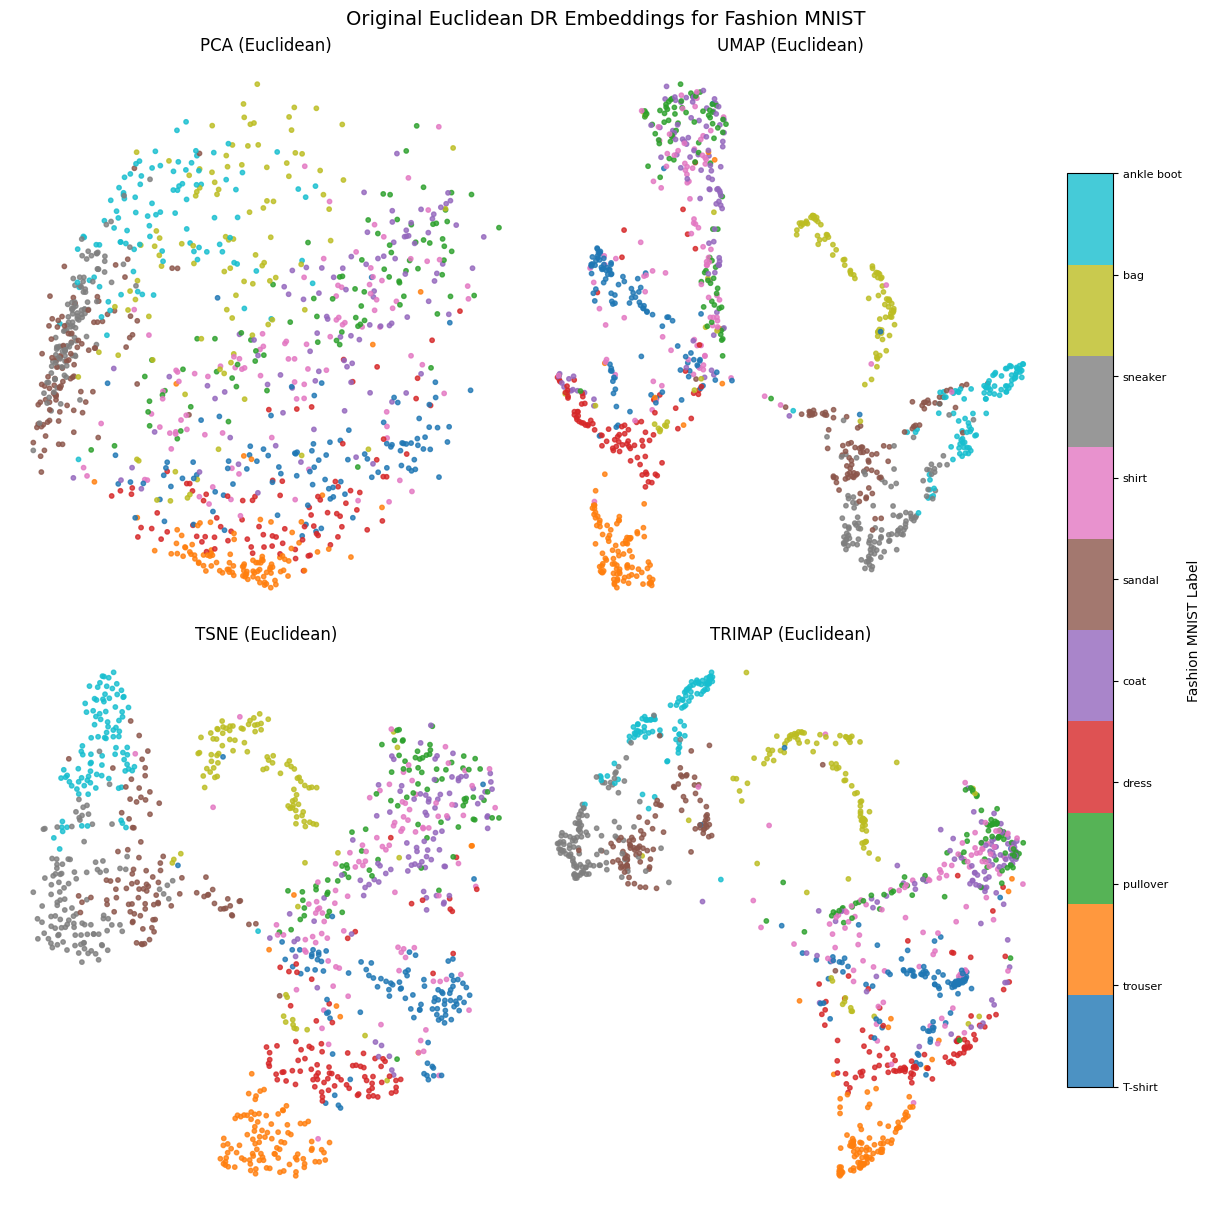

In [15]:
##plots original dr

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Fashion MNIST class names
fashion_labels = [
    "T-shirt", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"
]

# Load Fashion MNIST labels
(_, y), _ = fashion_mnist.load_data()
y = y[:1000]

methods = ["pca", "umap", 'tsne', 'trimap']
fig, axs = plt.subplots(2, 2, figsize=(12, 12), constrained_layout=True)
axs = axs.flatten()

for i, method in enumerate(methods):
    try:
        emb = np.load(f"output/original_embedding_{method}.npy")
        assert len(emb) == len(y), f"Mismatch: embedding has {len(emb)}, labels have {len(y)}"

        ax = axs[i]
        ax.set_title(f"{method.upper()} (Euclidean)", fontsize=12)

        scatter = ax.scatter(
            emb[:, 0], emb[:, 1],
            c=y, cmap='tab10', s=10, alpha=0.8
        )
        ax.axis("off")

    except Exception as e:
        print(f"Could not load {method}: {e}")
        axs[i].set_title(f"{method.upper()} (Error)")

# Add colorbar to the right side with class names
cbar = fig.colorbar(
    scatter, ax=axs, orientation='vertical',
    fraction=0.05, pad=0.02, shrink=0.8
)
cbar.set_label('Fashion MNIST Label', fontsize=10)
cbar.ax.set_yticklabels(fashion_labels)
cbar.ax.tick_params(labelsize=8)

plt.suptitle("Original Euclidean DR Embeddings for Fashion MNIST", fontsize=14)
plt.show()

/tmp/ipykernel_151/1243682618.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(fashion_labels)


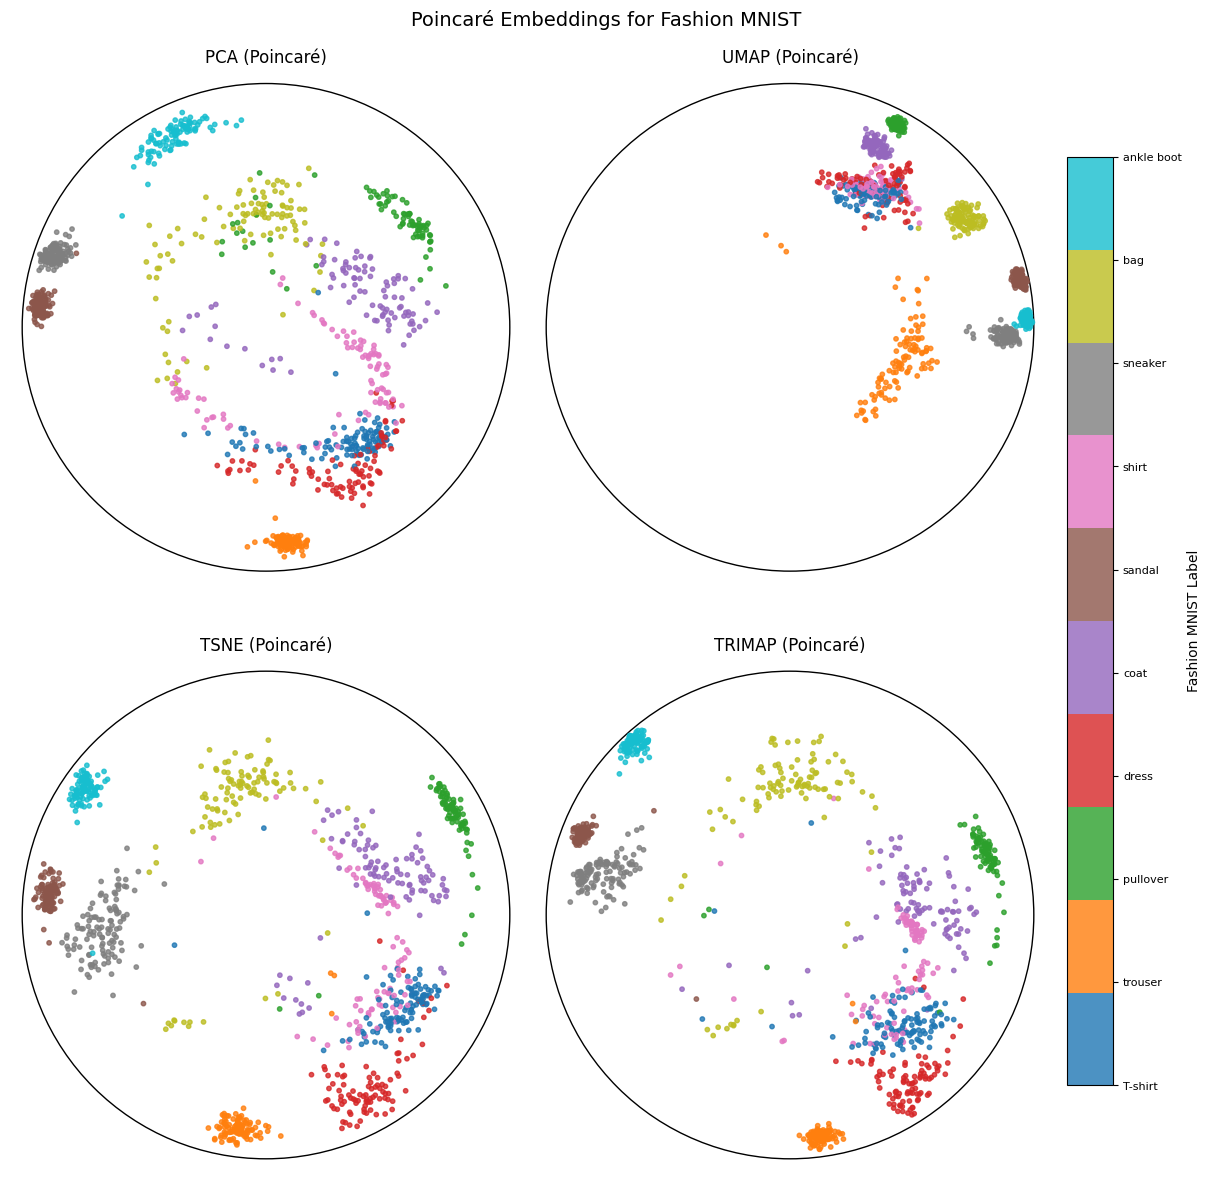

In [13]:
#plot hyperbolic 

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Fashion MNIST class names
fashion_labels = [
    "T-shirt", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"
]

# Load Fashion MNIST labels (first 1000)
(_, y), _ = fashion_mnist.load_data()
y = y[:1000]

methods = ["pca", "umap", 'tsne', 'trimap']
fig, axs = plt.subplots(2, 2, figsize=(12, 12), constrained_layout=True)
axs = axs.flatten()

for i, method in enumerate(methods):
    try:
        emb = np.load(f"output/embedding_{method}.npy")
        assert len(emb) == len(y), f"Mismatch: embedding has {len(emb)}, labels have {len(y)}"

        ax = axs[i]
        ax.set_title(f"{method.upper()} (Poincaré)", fontsize=12)
        ax.set_xlim(-1.05, 1.05)
        ax.set_ylim(-1.05, 1.05)
        ax.set_aspect('equal')
        ax.axis('off')

        # Draw Poincaré disk
        circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=1)
        ax.add_artist(circle)

        # Scatter plot
        scatter = ax.scatter(
            emb[:, 0], emb[:, 1],
            c=y, cmap='tab10', s=10, alpha=0.8
        )

    except Exception as e:
        print(f"Could not load {method}: {e}")
        axs[i].set_title(f"{method.upper()} (Error)")

# Add colorbar with class names
cbar = fig.colorbar(
    scatter, ax=axs, orientation='vertical',
    fraction=0.05, pad=0.02, shrink=0.8,
    location='right'
)
cbar.set_label('Fashion MNIST Label', fontsize=10)
cbar.ax.set_yticklabels(fashion_labels)
cbar.ax.tick_params(labelsize=8)

plt.suptitle("Poincaré Embeddings for Fashion MNIST", fontsize=14)
plt.show()


In [16]:
#metrics
import tracemalloc
import os
import numpy as np
import torch
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import trustworthiness
from scipy.stats import spearmanr
from tensorflow.keras.datasets import fashion_mnist
import geoopt
import pandas as pd
import time

# Load Fashion MNIST labels (2000 samples used in training)
(_, y), _ = fashion_mnist.load_data()
y = y[:1000]

methods = ["pca", "tsne", "umap", "trimap"]
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def mean_intra_inter_ratio(embedding, labels):
    dists = pairwise_distances(embedding)
    intra, inter = [], []
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] == labels[j]:
                intra.append(dists[i, j])
            else:
                inter.append(dists[i, j])
    intra = np.mean(intra)
    inter = np.mean(inter)
    return inter / intra if intra > 0 else 0

# Try loading precomputed semantic triplets
triplet_path = "/kaggle/working/semantic_triplets_fashion.npy"
triplets = None
if os.path.exists(triplet_path):
    triplets = torch.tensor(np.load(triplet_path), dtype=torch.long, device=device)

# Evaluate metrics
for method in methods:
    try:
        start_time = time.time()
        tracemalloc.start()

        emb_orig = np.load(f"/kaggle/working/output/original_embedding_{method}.npy")
        emb = np.load(f"/kaggle/working/output/embedding_{method}.npy")

        scores = {}
        for name, embedding in [("before", emb_orig), ("after", emb)]:
            silhouette = silhouette_score(embedding, y)
            db_index = davies_bouldin_score(embedding, y)
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(embedding, y)
            acc = np.mean(knn.predict(embedding) == y)
            global_score = mean_intra_inter_ratio(embedding, y)

            scores[f"silhouette_{name}"] = silhouette
            scores[f"db_index_{name}"] = db_index
            scores[f"knn_acc_{name}"] = acc
            scores[f"global_score_{name}"] = global_score

        high_dist = pairwise_distances(emb_orig)
        low_dist = pairwise_distances(emb)
        stress = np.sqrt(np.sum((high_dist - low_dist) ** 2) / np.sum(high_dist ** 2))
        flat_high = high_dist[np.triu_indices_from(high_dist, k=1)]
        flat_low = low_dist[np.triu_indices_from(low_dist, k=1)]
        spearman_corr = spearmanr(flat_high, flat_low).correlation
        trust = trustworthiness(emb_orig, emb, n_neighbors=5)

        scores["stress"] = stress
        scores["spearman_corr"] = spearman_corr
        scores["trustworthiness"] = trust

        if triplets is not None:
            emb_tensor = torch.tensor(emb, dtype=torch.float32, device=device)
            anchors = emb_tensor[triplets[:, 0]]
            positives = emb_tensor[triplets[:, 1]]
            negatives = emb_tensor[triplets[:, 2]]

            d_ap = torch.norm(anchors - positives, dim=1)
            d_an = torch.norm(anchors - negatives, dim=1)
            triplet_acc = (d_ap < d_an).float().mean().item()

            manifold = geoopt.PoincareBall(c=1.0)
            hyp_d_ap = manifold.dist(anchors, positives)
            hyp_d_an = manifold.dist(anchors, negatives)
            hyp_dist = torch.cat((hyp_d_ap, hyp_d_an)).mean().item()

            scores["triplet_acc"] = triplet_acc
            scores["hyperbolic_dist"] = hyp_dist

        # Record runtime and memory usage
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        scores["runtime_sec"] = end_time - start_time
        scores["peak_memory_mb"] = peak / 10**6
        tracemalloc.stop()

        results[method] = scores

    except Exception as e:
        results[method] = {"error": str(e)}

df = pd.DataFrame(results).T

print(df) 

        silhouette_before  db_index_before  knn_acc_before  \
pca             -0.021731         4.796909           0.648   
tsne             0.168944         2.142849           0.841   
umap             0.164564         3.035033           0.808   
trimap           0.165602         2.254532           0.768   

        global_score_before  silhouette_after  db_index_after  knn_acc_after  \
pca                1.995132          0.405146        1.437615          0.928   
tsne               2.780298          0.450331        0.987968          0.939   
umap               2.957582          0.463828        3.241883          0.888   
trimap             3.224385          0.448529        1.006305          0.942   

        global_score_after    stress  spearman_corr  trustworthiness  \
pca               4.818859  0.881198       0.734082         0.879743   
tsne              5.119205  0.973393       0.805068         0.910058   
umap              6.789317  0.909100       0.724978         0.859504   
